# MLP su dati epigenomici 

In [41]:
import nbimporter
from Import_data import get_df_class, get_df_epigenomic, get_df_sequence , get_type_of_nucl_from_list_of_sequence, convertToNum
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from keras.utils import to_categorical 
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve

sns.set(color_codes=True)

# RandomForest
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE, RandomOverSampler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV

#BO
from GPyOpt.methods import BayesianOptimization
from numpy.random import seed

#https://stackoverflow.com/questions/51480776/how-to-implement-ratio-based-smote-oversampling-while-cv-ing-dataset
from imblearn.pipeline import Pipeline
from sklearn.metrics import make_scorer

#path
path_relazione = '../../relazione/img/'
path_output = '../output/'

%matplotlib inline

random_state = 42
seed(random_state)
problem = ['A-E','I-E']
line = 'GM12878'

In [2]:
cell_line = line
path_c = f'../data/classes/{cell_line}_class.csv'
path_e = f'../data/epigenomic-data/{cell_line}.csv'
path_s = f'../data/sequences/{cell_line}.fa'

df_c = get_df_class(path_c)
df_e = get_df_epigenomic(path_e)
df_s = get_df_sequence(path_s)

problem_slug = "_vs_".join(problem)
problem_slug

'A-E_vs_I-E'

## Zero centering

In [3]:
df_e.head()

ATF2  ATF3   BATF  BCL11A   BCL3  BCLAF1  BHLHE40  BRCA1  C-FOS(FOS)  \
0  7.46  3.67  16.20   20.02  28.27    9.01    13.74   2.31        2.39   
1  3.07  3.54   1.17    1.06   6.44    2.67     9.22   1.70        0.22   
2  3.45  0.86   2.21    3.46   4.35    2.10    22.07   1.63        0.87   
3  8.03  1.77   3.75    4.51   8.54    4.00    19.74   2.55        0.15   
4  2.89  1.15   1.06    2.39   4.21    3.64     7.43   2.32        0.69   

   C-MYC(MYC)  ...  USF1   USF2  WHIP(WRNIP1)   YY1  ZBTB33   ZEB1  ZNF143  \
0        6.30  ...  4.21   4.94          2.11  0.00    3.82  24.44    3.45   
1        8.30  ...  3.01   3.33          1.31  0.00    0.27   4.47    2.64   
2        8.65  ...  4.16  11.26          3.91  0.09    2.01   7.15    1.64   
3        3.25  ...  1.59   2.63          3.34  0.00    2.01   3.69    0.76   
4        5.45  ...  2.12   5.33          3.83  0.00    0.83   9.19    1.04   

   ZNF274  ZNF384  ZZZ3  
0    0.10    3.62  0.15  
1    0.02    1.01  0.00  
2    0.00    1.43  0.10  
3    0.00    7.21  0.00  
4    0.00    4.10  0.04  

[5 rows x 101 columns]

In [4]:
df_e.describe()

ATF2           ATF3           BATF         BCL11A  \
count  223049.000000  223049.000000  223049.000000  223049.000000   
mean        1.081205       1.067037       0.910783       0.986133   
std         1.610495       1.185601       1.759527       1.173531   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.380000       0.280000       0.310000       0.380000   
50%         0.680000       0.800000       0.630000       0.770000   
75%         1.120000       1.520000       1.070000       1.270000   
max        37.490000      40.890000      85.900000      58.200000   

                BCL3         BCLAF1        BHLHE40          BRCA1  \
count  223049.000000  223049.000000  223049.000000  223049.000000   
mean        1.157398       1.083511       1.060821       0.838814   
std         1.691762       1.065153       2.423607       1.123083   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.280000       0.460000       0.270000       0.370000   
50%         0.730000       0.850000       0.550000       0.700000   
75%         1.390000       1.360000       1.000000       1.110000   
max        62.530000      26.880000      78.540000      91.800000   

          C-FOS(FOS)     C-MYC(MYC)  ...           USF1           USF2  \
count  223049.000000  223049.000000  ...  223049.000000  223049.000000   
mean        0.674162       1.182654  ...       1.329388       0.960388   
std         0.992383       1.712709  ...       1.948617       1.925306   
min         0.000000       0.000000  ...       0.000000       0.000000   
25%         0.000000       0.250000  ...       0.460000       0.290000   
50%         0.390000       0.770000  ...       0.990000       0.640000   
75%         1.030000       1.520000  ...       1.700000       1.170000   
max        47.510000      61.440000  ...      56.320000     126.610000   

        WHIP(WRNIP1)            YY1         ZBTB33           ZEB1  \
count  223049.000000  223049.000000  223049.000000  223049.000000   
mean        0.854302       0.551228       0.958348       1.471804   
std         0.842123       0.729927       1.179068       2.440150   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.290000       0.000000       0.400000       0.000000   
50%         0.650000       0.300000       0.800000       0.860000   
75%         1.180000       0.840000       1.310000       1.940000   
max        22.810000      32.100000      48.910000     162.190000   

              ZNF143         ZNF274         ZNF384           ZZZ3  
count  223049.000000  223049.000000  223049.000000  223049.000000  
mean        0.771373       0.563365       0.804293       0.564000  
std         1.174013       0.563737       1.090890       0.538925  
min         0.000000       0.000000       0.000000       0.000000  
25%         0.280000       0.130000       0.330000       0.160000  
50%         0.540000       0.420000       0.650000       0.430000  
75%         0.930000       0.830000       1.050000       0.820000  
max        66.470000      18.170000      74.810000      25.480000  

[8 rows x 101 columns]

In [5]:
df_e = df_e.subtract(df_e.mean())
df_e.describe()

ATF2          ATF3          BATF        BCL11A          BCL3  \
count  2.230490e+05  2.230490e+05  2.230490e+05  2.230490e+05  2.230490e+05   
mean  -1.397582e-15  1.238710e-13 -1.251035e-13  9.690311e-15 -9.175520e-15   
std    1.610495e+00  1.185601e+00  1.759527e+00  1.173531e+00  1.691762e+00   
min   -1.081205e+00 -1.067037e+00 -9.107830e-01 -9.861332e-01 -1.157398e+00   
25%   -7.012050e-01 -7.870365e-01 -6.007830e-01 -6.061332e-01 -8.773983e-01   
50%   -4.012050e-01 -2.670365e-01 -2.807830e-01 -2.161332e-01 -4.273983e-01   
75%    3.879497e-02  4.529635e-01  1.592170e-01  2.838668e-01  2.326017e-01   
max    3.640879e+01  3.982296e+01  8.498922e+01  5.721387e+01  6.137260e+01   

             BCLAF1       BHLHE40         BRCA1    C-FOS(FOS)    C-MYC(MYC)  \
count  2.230490e+05  2.230490e+05  2.230490e+05  2.230490e+05  2.230490e+05   
mean   4.204979e-14  8.165203e-14  1.941477e-14 -8.643169e-14  1.337846e-14   
std    1.065153e+00  2.423607e+00  1.123083e+00  9.923831e-01  1.712709e+00   
min   -1.083511e+00 -1.060821e+00 -8.388135e-01 -6.741616e-01 -1.182654e+00   
25%   -6.235110e-01 -7.908207e-01 -4.688135e-01 -6.741616e-01 -9.326538e-01   
50%   -2.335110e-01 -5.108207e-01 -1.388135e-01 -2.841616e-01 -4.126538e-01   
75%    2.764890e-01 -6.082072e-02  2.711865e-01  3.558384e-01  3.373462e-01   
max    2.579649e+01  7.747918e+01  9.096119e+01  4.683584e+01  6.025735e+01   

       ...          USF1          USF2  WHIP(WRNIP1)           YY1  \
count  ...  2.230490e+05  2.230490e+05  2.230490e+05  2.230490e+05   
mean   ... -1.782493e-13  6.217966e-14 -3.557463e-14  6.320721e-15   
std    ...  1.948617e+00  1.925306e+00  8.421232e-01  7.299267e-01   
min    ... -1.329388e+00 -9.603879e-01 -8.543023e-01 -5.512278e-01   
25%    ... -8.693880e-01 -6.703879e-01 -5.643023e-01 -5.512278e-01   
50%    ... -3.393880e-01 -3.203879e-01 -2.043023e-01 -2.512278e-01   
75%    ...  3.706120e-01  2.096121e-01  3.256977e-01  2.887722e-01   
max    ...  5.499061e+01  1.256496e+02  2.195570e+01  3.154877e+01   

             ZBTB33          ZEB1        ZNF143        ZNF274        ZNF384  \
count  2.230490e+05  2.230490e+05  2.230490e+05  2.230490e+05  2.230490e+05   
mean  -1.313381e-14  1.510999e-13 -1.081159e-13  9.001969e-15 -7.732575e-15   
std    1.179068e+00  2.440150e+00  1.174013e+00  5.637368e-01  1.090890e+00   
min   -9.583479e-01 -1.471804e+00 -7.713731e-01 -5.633653e-01 -8.042930e-01   
25%   -5.583479e-01 -1.471804e+00 -4.913731e-01 -4.333653e-01 -4.742930e-01   
50%   -1.583479e-01 -6.118035e-01 -2.313731e-01 -1.433653e-01 -1.542930e-01   
75%    3.516521e-01  4.681965e-01  1.586269e-01  2.666347e-01  2.457070e-01   
max    4.795165e+01  1.607182e+02  6.569863e+01  1.760663e+01  7.400571e+01   

               ZZZ3  
count  2.230490e+05  
mean   2.194897e-14  
std    5.389251e-01  
min   -5.640001e-01  
25%   -4.040001e-01  
50%   -1.340001e-01  
75%    2.559999e-01  
max    2.491600e+01  

[8 rows x 101 columns]

In [6]:
# conversione etichette one_hot (si potrebbe fare anche singolo)
type_of_class = sorted(list(df_c['class'].unique()))
lab2int = convertToNum(type_of_class)
classes = np.asarray([  lab2int(el) for el in df_c["class"].values])
print(type_of_class)
classes

['A-E', 'A-P', 'A-X', 'I-E', 'I-P', 'I-X', 'UK']


array([0, 0, 0, ..., 6, 6, 6])

In [7]:
int_labels = [lab2int(el) for el in problem]
int_labels, problem

([0, 3], ['A-E', 'I-E'])

In [8]:
#selezione del problema
X = df_e.values
y = classes
mask = [ el in int_labels for el in classes ]
X,y = X[mask],y[mask]
set(y), len(y)

({0, 3}, 31034)

In [9]:
def _create01mapping(elements):
    d = { k:v for v,k in enumerate(elements)}
    return lambda x : d[x]

label_mapping = _create01mapping(set(y))
y = np.array([ label_mapping(el) for el in y])

# TP è sempre la classe meno numerosa, è il soggetto di interesse
sum(y == 0),len(y==1)
if sum(y==0) < len(y)/2:
    y = 1-y #flipping
y

array([1, 1, 1, ..., 0, 0, 0])

In [10]:
randSampler = RandomOverSampler(random_state=random_state)

def resampler(x,y):
    # https://stackoverflow.com/questions/34972142/sklearn-logistic-regression-valueerror-found-array-with-dim-3-estimator-expec
    x, y = randSampler.fit_resample(x, y)
    return x,y

## Migliore soglia: Youden index
Viene calcolato sul miglior risultato della ROC ma poi testato sul test

In [131]:
def getBestThreshold(y_test,y_pred_prob):
    fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_prob,pos_label= 1)
    sensitivity = tpr_keras[len(tpr_keras):0:-1] #correctly classified as positive
    specificity = 1 - fpr_keras[len(tpr_keras):0:-1] #correctly classified as negative
    youden_index = sensitivity + specificity -1
    thresholds_keras = thresholds_keras[len(tpr_keras):0:-1]
    max_threshold_y = thresholds_keras[youden_index.argmax()]
    return max_threshold_y

## Ricerca intorni di parametri buoni

In [11]:
import keras
from keras.callbacks import Callback
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras import losses
from keras.utils import plot_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import RandomOverSampler

In [12]:
#https://medium.com/@thongonary/how-to-compute-f1-score-for-each-epoch-in-keras-a1acd17715a2
class Metrics(Callback):
    def on_train_begin(self, logs={}):
        self.val_f1s = []
        self.val_recalls = []
        self.val_precisions = []

    def on_epoch_end(self, epoch, logs={}):
        val_predict = (np.asarray(self.model.predict(self.model.validation_data[0]))).round()
        val_targ = self.model.validation_data[1]
        _val_f1 = f1_score(val_targ, val_predict)
        _val_recall = recall_score(val_targ, val_predict)
        _val_precision = precision_score(val_targ, val_predict)
        self.val_f1s.append(_val_f1)
        self.val_recalls.append(_val_recall)
        self.val_precisions.append(_val_precision)
        print(f'— val_f1: {_val_f1:.4f} — val_precision: {_val_precision:.4f} — val_recall {_val_recall:.4f}')
        return

metrics = Metrics()

In [20]:
input_shape = X.shape
print(f'input shape {input_shape}')

def generateMlpModel(h1=256,h2=512,h3=64,a1='relu',a2='relu',a3='relu',a4='sigmoid',d1=0.5,d2=0.5):
    model = Sequential()
    model.add(Dense(h1, activation=a1, input_shape=(input_shape[1],)))
    model.add(Dropout(d1))
    model.add(Dense(h2, activation=a2))
    model.add(Dropout(d2))
    model.add(Dense(h3, activation=a3))

    model.add(Dense(1, activation=a4))

    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    return model
#model.summary()

input shape (31034, 101)


In [25]:
#plot_model(model, to_file='model su dati epi.png',show_shapes=True)

In [45]:
n_split = 4
batch_size = 16
epochs = 3
skf = StratifiedKFold(n_splits=n_split,random_state=random_state)

conf_matrix = np.zeros([2,2])
best_model = None

for nth, other in enumerate(skf.split(X,y)):
    train_index, test_index = other
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    X_train_balanced, y_train_balanced = resampler(X_train, y_train)
    
    model = generateMlpModel()
    model.fit(X_train_balanced, y_train_balanced,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_test, y_test))
    
    score = model.evaluate(X_test, y_test, verbose=0)
    print('Test loss:', score[0])
    print('Test accuracy:\n', score[1])
    
    
    y_pred_prob = model.predict(X_train).ravel()
    
    #con la soglia migliore che massimizza il youden_index
    max_threshold_y = getBestThreshold(y_train,y_pred_prob)
    
    y_pred_label = y_pred_prob > max_threshold_y
    cm = confusion_matrix(y_test, y_pred_label)
    conf_matrix = conf_matrix + cm
    
    print(conf_matrix)
    best_model = model

Train on 42234 samples, validate on 7759 samples
Epoch 1/3
42234/42234 [==============================] - 23s 539us/step - loss: 0.1378 - acc: 0.9546 - val_loss: 0.1007 - val_acc: 0.9640
Epoch 2/3
42234/42234 [==============================] - 20s 484us/step - loss: 0.0919 - acc: 0.9667 - val_loss: 0.0796 - val_acc: 0.9727
Epoch 3/3
42234/42234 [==============================] - 32s 750us/step - loss: 0.0765 - acc: 0.9718 - val_loss: 0.0941 - val_acc: 0.9722
Test loss: 0.09405129362429866
Test accuracy:
 0.9721613610001288
[[6853.  186.]
 [  38.  682.]]
Train on 42234 samples, validate on 7759 samples
Epoch 1/3
42234/42234 [==============================] - 27s 647us/step - loss: 0.1446 - acc: 0.9519 - val_loss: 0.1173 - val_acc: 0.9589
Epoch 2/3
42234/42234 [==============================] - 17s 405us/step - loss: 0.0967 - acc: 0.9646 - val_loss: 0.0963 - val_acc: 0.9669
Epoch 3/3
42234/42234 [==============================] - 17s 403us/step - loss: 0.0783 - acc: 0.9701 - val_loss: 0.

## Analisi

In [56]:
sk = StratifiedKFold(n_splits=n_split)
iterator = iter(skf.split(X,y))
train_index, test_index = next(iterator)
train_index, test_index = other
X_train, X_test = X[train_index], X[test_index]
y_train, y_test = y[train_index], y[test_index]
X_train_balanced, y_train_balanced = resampler(X_train, y_train)

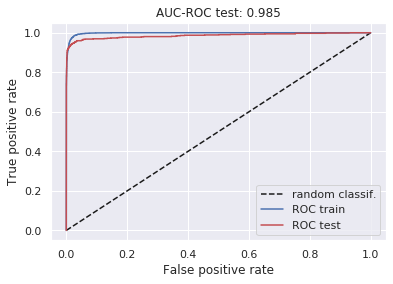

In [147]:
y_pred_keras = best_model.predict(X_train).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_train, y_pred_keras,pos_label= 1)
y_test_pred_keras = best_model.predict(X_test).ravel()
fpr_test_keras, tpr_test_keras, thresholds_test_keras = roc_curve(y_test, y_test_pred_keras,pos_label= 1)
# Print ROC curve
# Print AUC
auc = np.trapz(tpr_test_keras,fpr_test_keras)

plt.title(f'AUC-ROC test: {auc:.3f}')

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras,tpr_keras,'b')
plt.plot(fpr_test_keras,tpr_test_keras,'r')
plt.legend(['random classif.','ROC train','ROC test'])
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.savefig(path_relazione + 'roc_cnn_epi.svg')
plt.show() 

### Youden index
Un possibile buon valore di cut-off per la classificazione è dato dalla massimizzazione dei veri positivi (tpr) e dai veri negativi (1-fpr).

In [148]:
sensitivity = tpr_keras[len(tpr_keras):0:-1] #correctly classified as positive
specificity = 1 - fpr_keras[len(tpr_keras):0:-1] #correctly classified as negative
thresholds_keras = thresholds_keras[len(tpr_keras):0:-1]
youden_index = sensitivity + specificity -1
max_pos = youden_index.argmax()
max_threshold_y = thresholds_keras[max_pos]

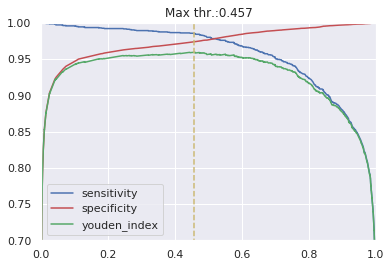

In [153]:
plt.title(f'Max thr.:{max_threshold_y:.3f}')
plt.legend(["sensitivity","specificity","Youden","Max threshold"])
plt.plot(thresholds_keras, sensitivity,'b')
plt.plot(thresholds_keras, specificity,'r')
plt.plot(thresholds_keras, youden_index,'g')
plt.plot([max_threshold_y,max_threshold_y], [0,1],'y--')
plt.savefig(path_relazione + 'youden_index_mpl_epi.pdf')
plt.legend(['sensitivity','specificity','youden_index'])
plt.xlim([0.0,1.0])
plt.ylim([0.7,1.0])
plt.show()

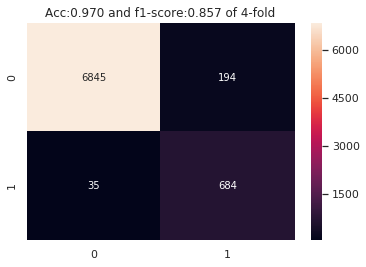

In [154]:
y_pred = best_model.predict(X_test)
y_pred =(y_pred>max_threshold_y)

cm = confusion_matrix(y_test, y_pred)
f1 = f1_score(y_test,y_pred)
accuracy = (cm[0][0] + cm[1][1])/(cm.flatten().sum())
plotted = sns.heatmap(cm,annot=True,fmt="d").set_title(f'Acc:{accuracy:.3f} and f1-score:{f1:.3f} of {n_split}-fold')
fig = plotted.get_figure()
fig.savefig(path_relazione + 'best_confusion_mpl_epi.pdf')